In [1]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn
from lenskit.algorithms import user_knn, tf, basic

from lenskit import topn

In [3]:
import pandas as pd

In [4]:
%matplotlib inline

In [6]:
df = pd.read_csv("./dataset/vlog_dataset.csv")
print( df.head() )

print( len(pd.unique(df['user_id'])) )

   user_id gender  age                 country  vlog_id     tag  time_spent  \
0     8861      M   52             Afghanistan     8481  Travel          18   
1     8861      M   52             Afghanistan     8145  Movies           8   
2     8861      M   52             Afghanistan     7195  Travel          21   
3     5545      M   30          American Samoa     2425  Movies           5   
4     2168      F   53  Bosnia and Herzegovina     4864  Health           9   

   like  comment  save  
0     1        1     1  
1     1        0     0  
2     0        1     1  
3     1        0     0  
4     1        0     0  
5072


In [7]:
Bias = basic.Bias(damping=5)
Pop = basic.Popular()
II = item_knn.ItemItem(20, save_nbrs=2500)
UU = user_knn.UserUser(30)
ALS = als.BiasedMF(50)
IALS = als.ImplicitMF(50)
BPR = tf.BPR(50)
TFMF = tf.IntegratedBiasMF(50)

In [8]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [9]:
df = df.rename(columns={'user_id': 'user', 'vlog_id': 'item'})

result = []
for i in range(0, df.shape[0]) : 
    result.append(5*df['like'][i] + df['comment'][i] + 4*df['save'][i])

df['rating'] = result

all_recs = []
test_data = []
for train, test in xf.partition_users(df, 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', II, train, test))
    all_recs.append(eval('UserUser', UU, train, test))
    all_recs.append(eval('BPR', BPR, train, test))

Epoch 1/5
1/1 [==============================] - 0s 483ms/step - loss: 0.6981
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 0.6974
Epoch 3/5
1/1 [==============================] - 0s 23ms/step - loss: 0.6969
Epoch 4/5
1/1 [==============================] - 0s 22ms/step - loss: 0.6962
Epoch 5/5
1/1 [==============================] - 0s 20ms/step - loss: 0.6952
Epoch 1/5
1/1 [==============================] - 0s 433ms/step - loss: 0.6982
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 0.6977
Epoch 3/5
1/1 [==============================] - 0s 19ms/step - loss: 0.6968
Epoch 4/5
1/1 [==============================] - 0s 19ms/step - loss: 0.6962
Epoch 5/5
1/1 [==============================] - 0s 21ms/step - loss: 0.6952
Epoch 1/5
1/1 [==============================] - 0s 421ms/step - loss: 0.6985
Epoch 2/5
1/1 [==============================] - 0s 19ms/step - loss: 0.6977
Epoch 3/5
1/1 [==============================] - 0s 19ms/step - loss: 0.6

In [10]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,7352,5.666667,36,1,ItemItem
1,9125,2.500000,101,1,ItemItem
2,440,5.500000,113,1,ItemItem
3,2846,5.833333,160,1,ItemItem
4,4081,3.333333,160,2,ItemItem


In [11]:
test_data = pd.concat(test_data, ignore_index=True)

In [12]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

e:\wiw\.venv\lib\site-packages\lenskit\metrics\topn.py:111: RuntimeWarning: invalid value encountered in double_scalars
  return achieved / ideal


nrecs      ndcg
Algorithm user                 
BPR       6     100.0  0.000000
          15    100.0  0.270238
          24    100.0  0.000000
          35    100.0       NaN
          36    100.0  0.000000

In [13]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
BPR         0.002014
ItemItem    0.000000
UserUser    0.001873
Name: ndcg, dtype: float64

<AxesSubplot:xlabel='Algorithm'>

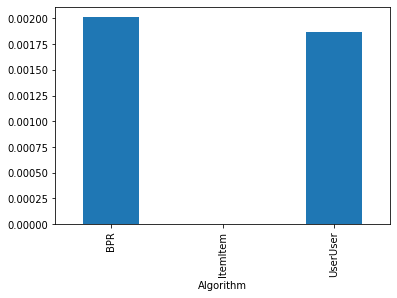

In [14]:
results.groupby('Algorithm').ndcg.mean().plot.bar()